In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm, trange
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [23]:
train = pd.read_csv('../input/energy-anomaly-detection/train.csv')
train.head()

,building_id,timestamp,meter_reading,anomaly
0,1,2016-01-01 00:00:00,NaN,0
1,32,2016-01-01 00:00:00,NaN,0
2,41,2016-01-01 00:00:00,NaN,0
3,55,2016-01-01 00:00:00,NaN,0
4,69,2016-01-01 00:00:00,NaN,0


In [24]:
train.shape

(1749494, 4)

In [25]:
train.isnull().sum()

building_id           0
timestamp             0
meter_reading    107653
anomaly               0
dtype: int64

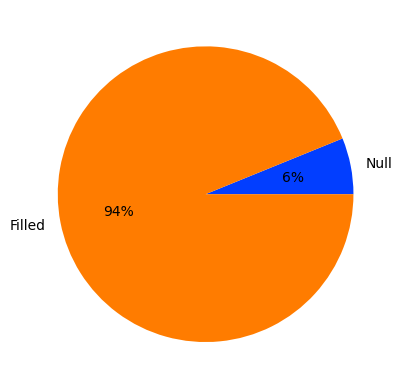

In [26]:
k = train.isnull().sum().sum()
plt.pie([k, train.shape[0]-k], labels=['Null', 'Filled']\
        , colors=sb.color_palette('bright'), autopct='%.0f%%')
plt.show()


<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">So, around <code>6%</code> of the total entry's have null value in the meter_reading column.</p>

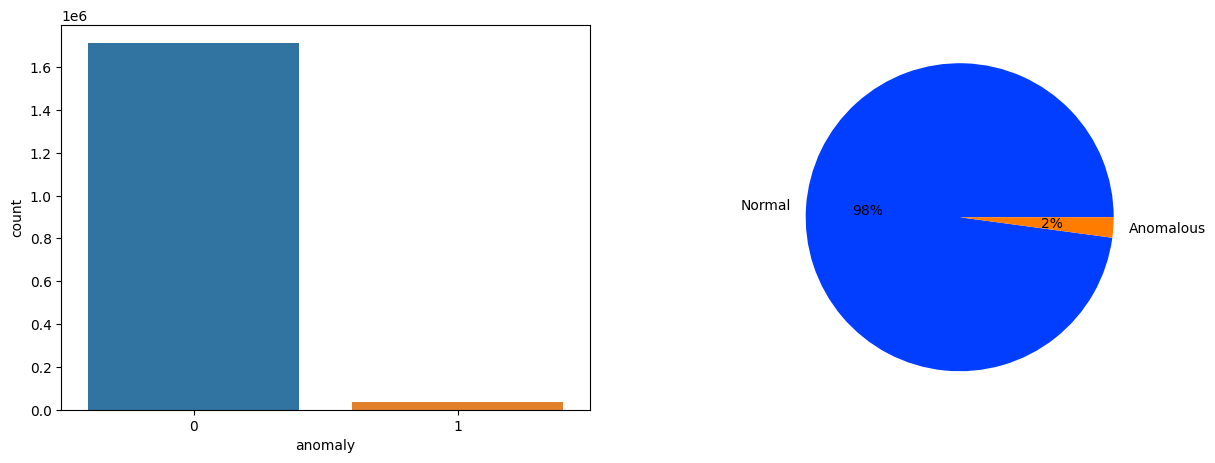

In [27]:
plt.subplots(figsize=(15,5))
plt.subplot(1,2,1)
sb.countplot(x=train['anomaly'])
plt.subplot(1,2,2)
data = train['anomaly'].value_counts()
plt.pie(data, labels=['Normal', 'Anomalous'], colors=sb.color_palette('bright'), autopct='%.0f%%')
plt.show()

In [28]:
train['anomaly'].value_counts()

anomaly
0    1712198
1      37296
Name: count, dtype: int64

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">As expected generally in a anomaly detection problem data imbalance is an obvious case because anomalies as rare cases which do not occur oftenly else there must be some other default.</p>

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749494 entries, 0 to 1749493
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   timestamp      object 
 2   meter_reading  float64
 3   anomaly        int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 53.4+ MB


In [30]:
mean_reading = train.groupby('building_id')['meter_reading'].mean()

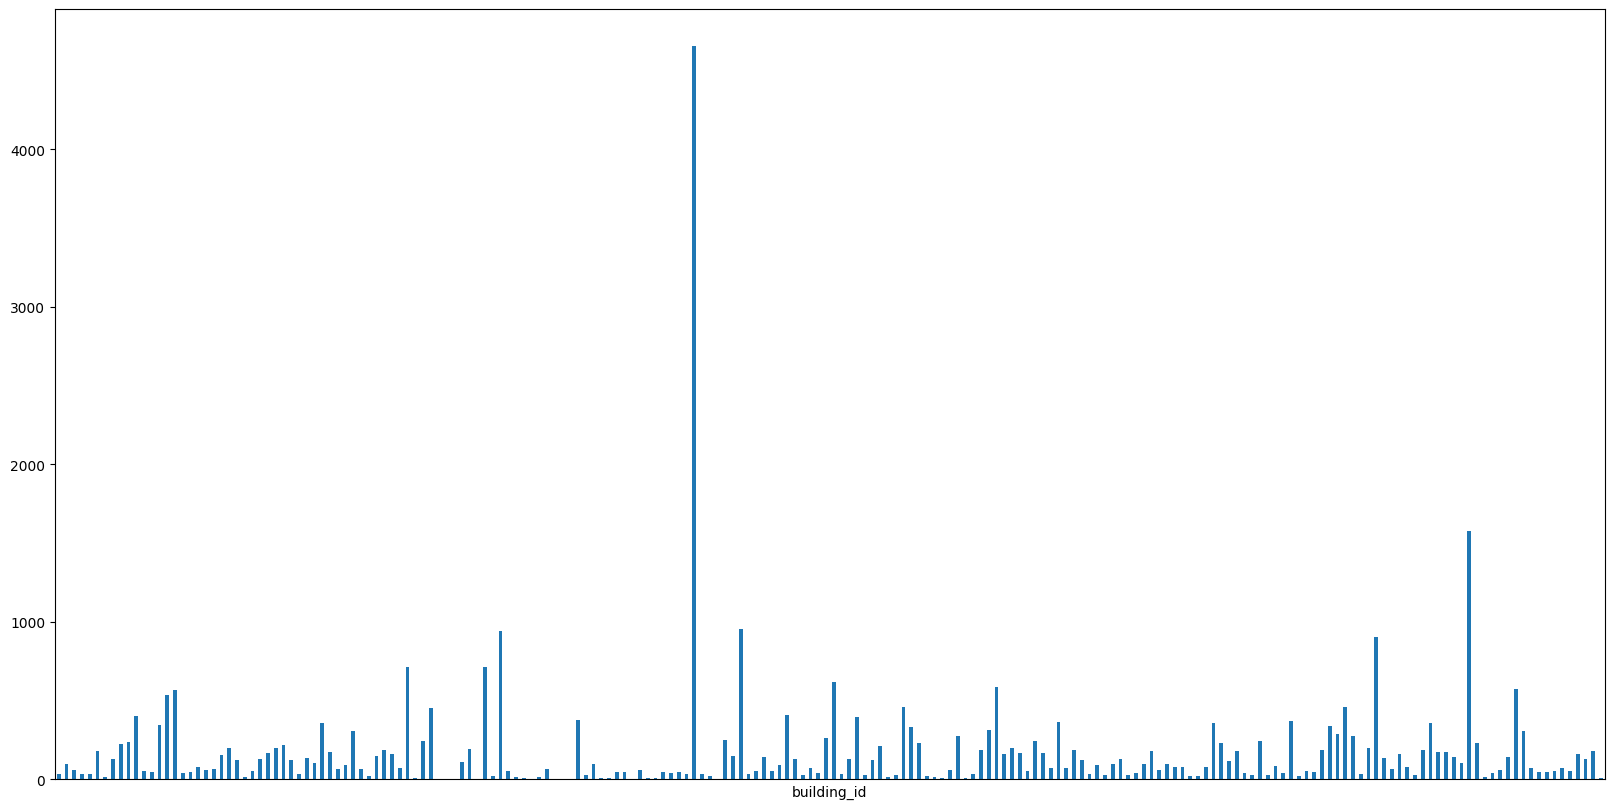

In [31]:
plt.figure(figsize=(20,10))
mean_reading.plot.bar()
plt.xticks([])
plt.show()

In [32]:
mean_reading.idxmax()

801

<ul style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0"><li>The building with id equal to <code>801</code> has mean <code>meter_reading</code> too high as compare to other buildings seems like a skyscrapper to me😆 and some buildings seems to have very low mean <code>meter_reading</code>.</li><li>

This mean statistics is for throughout the year. We will see further in this notebook is there some variation in the mean usage during different days/month.</li></ul>

In [33]:
def add_date_time(data):
  new = data['timestamp'].str.split(' ', n = 1, expand=True)
  data['date'] = new[0]
  data['time'] = new[1]
  data['time'] = data['time'].str[:2].astype(int)
  data = data.drop(['timestamp'], axis=1)

  return data

train = add_date_time(train)
train.head()

,building_id,meter_reading,anomaly,date,time
0,1,NaN,0,2016-01-01,0
1,32,NaN,0,2016-01-01,0
2,41,NaN,0,2016-01-01,0
3,55,NaN,0,2016-01-01,0
4,69,NaN,0,2016-01-01,0


In [34]:
def add_month_day(data):
  data['month'] = data['date'].str[5:7].astype(int)
  data['day'] = data['date'].str[-2:].astype(int)
  data = data.drop(['date'], axis=1)

  return data

train = add_month_day(train)
train.head()

,building_id,meter_reading,anomaly,time,month,day
0,1,NaN,0,0,1,1
1,32,NaN,0,0,1,1
2,41,NaN,0,0,1,1
3,55,NaN,0,0,1,1
4,69,NaN,0,0,1,1


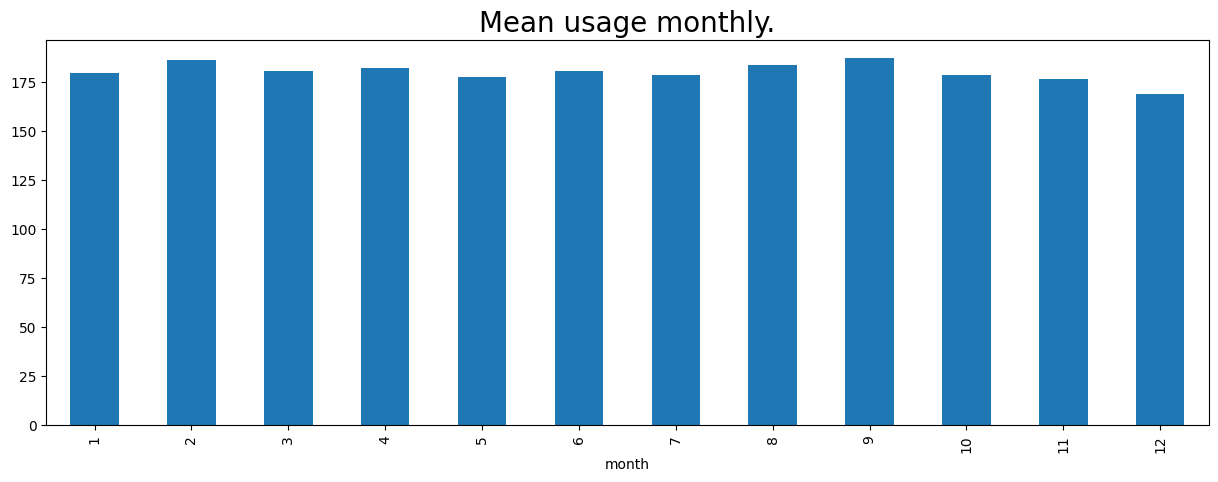

In [35]:
plt.figure(figsize=(15,5))
train.groupby('month').mean()['meter_reading'].plot.bar()
plt.title('Mean usage monthly.', fontsize=20)
plt.show()

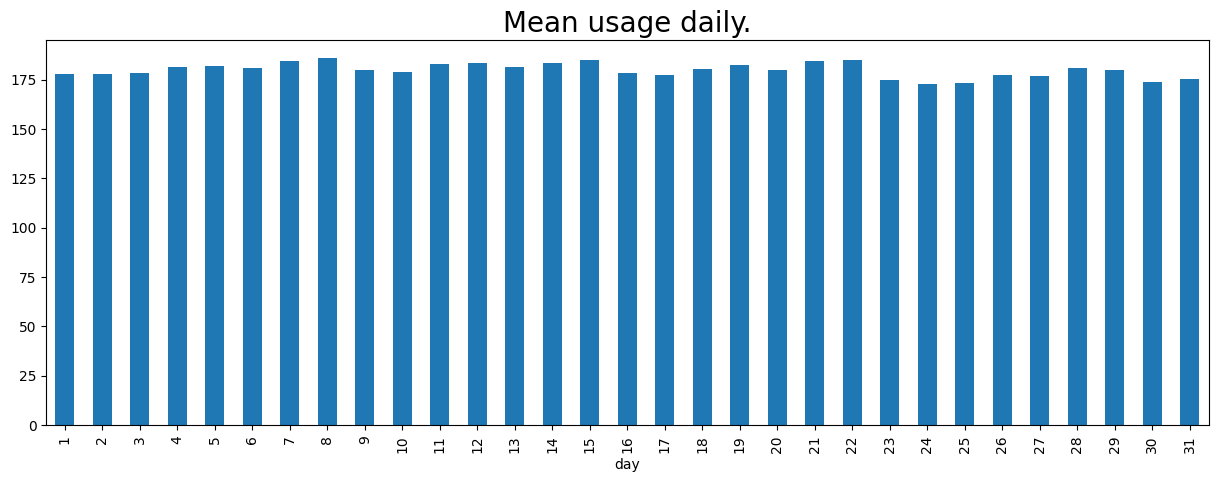

In [36]:
plt.figure(figsize=(15,5))
train.groupby('day').mean()['meter_reading'].plot.bar()
plt.title('Mean usage daily.', fontsize=20)
plt.show()

In [37]:
train.head()

,building_id,meter_reading,anomaly,time,month,day
0,1,NaN,0,0,1,1
1,32,NaN,0,0,1,1
2,41,NaN,0,0,1,1
3,55,NaN,0,0,1,1
4,69,NaN,0,0,1,1


In [38]:
# Feature denoting whether it was a weekday or weekend.
def weekend_or_weekday(year,month,day):
    
    d = datetime(year,month,day)
    if d.weekday()>4:
        return 1
    else:
        return 0


train['weekend'] = train.apply(lambda x:\
                               weekend_or_weekday(int(2016),int(x['month']),int(x['day'])),axis=1)
train.head()

,building_id,meter_reading,anomaly,time,month,day,weekend
0,1,NaN,0,0,1,1,0
1,32,NaN,0,0,1,1,0
2,41,NaN,0,0,1,1,0
3,55,NaN,0,0,1,1,0
4,69,NaN,0,0,1,1,0


In [39]:
train['weekend'].value_counts()

weekend
0    1247563
1     501931
Name: count, dtype: int64

In [41]:
def impute_nulls(data):
    mean_reading = data.groupby('building_id').mean()['meter_reading']
    building_id = mean_reading.index
    values = mean_reading.values
    
    for i, idx in enumerate(building_id):
        data[data['building_id']==idx] = data[data['building_id']==idx].fillna(values[i]) 
    
    return data

train = impute_nulls(train)

In [42]:
train.isnull().sum()

building_id      0
meter_reading    0
anomaly          0
time             0
month            0
day              0
weekend          0
dtype: int64

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">So as for each building average reading is different here i am grouping the data building wise and training them with RandomForest and XGBoost</p>

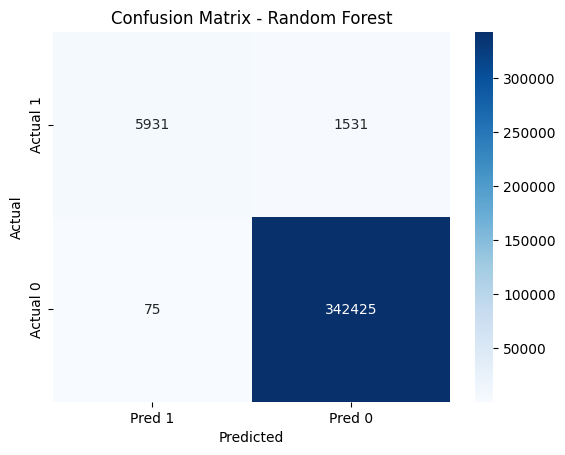


Classification Report for Random Forest:

              precision    recall  f1-score   support

           0     0.9955    0.9998    0.9977    342500
           1     0.9875    0.7948    0.8808      7462

    accuracy                         0.9954    349962
   macro avg     0.9915    0.8973    0.9392    349962
weighted avg     0.9954    0.9954    0.9952    349962



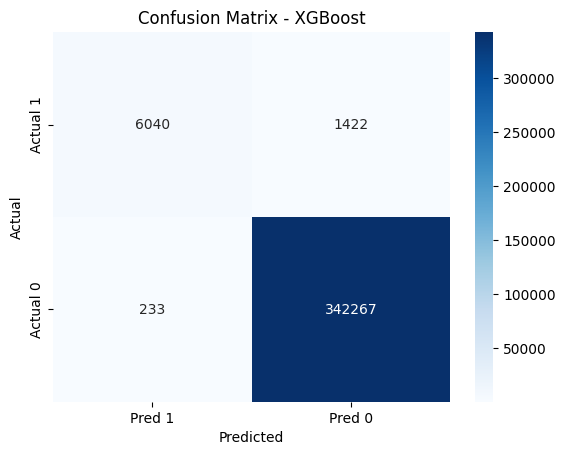


Classification Report for XGBoost:

              precision    recall  f1-score   support

           0     0.9959    0.9993    0.9976    342500
           1     0.9629    0.8094    0.8795      7462

    accuracy                         0.9953    349962
   macro avg     0.9794    0.9044    0.9385    349962
weighted avg     0.9952    0.9953    0.9951    349962



In [57]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming your dataset is called `train`
building_ids = train['building_id'].unique()

# Store predictions and ground truth
all_y_test_rf, all_y_pred_rf = [], []
all_y_test_xgb, all_y_pred_xgb = [], []

for b_id in building_ids:
    df = train[train['building_id'] == b_id]

    # Skip if there's not enough data for splitting
    if df.shape[0] < 10 or df['anomaly'].nunique() < 2:
        continue

    X = df.drop(columns=["building_id", "anomaly"])
    y = df["anomaly"]

    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

    # RF
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)

    # XGB
    xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)

    # Append
    all_y_test_rf.extend(y_test)
    all_y_pred_rf.extend(y_pred_rf)

    all_y_test_xgb.extend(y_test)
    all_y_pred_xgb.extend(y_pred_xgb)

# Plot confusion matrices
def plot_cm_and_metrics(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Pred 1", "Pred 0"], yticklabels=["Actual 1", "Actual 0"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred, digits=4))

# Final RF results
plot_cm_and_metrics(all_y_test_rf, all_y_pred_rf, "Random Forest")

# Final XGB results
plot_cm_and_metrics(all_y_test_xgb, all_y_pred_xgb, "XGBoost")


<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">
We trained both Random Forest and XGBoost models separately for each building by grouping the data building-wise. After evaluating their performance, we found that both models achieved over 99% accuracy. However, accuracy alone can be misleading—especially when the dataset is imbalanced with very few anomalies compared to normal readings.</p>






<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">
To get a more reliable measure of performance, we also have to analyze the precision, recall. These metrics help us understand how well the models are identifying anomalies without missing them (recall) or falsely flagging normal readings (precision).</p>



<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">
When comparing the models, Random Forest slightly outperformed XGBoost in terms of F1-score and accuracy. Therefore, we selected Random Forest as the preferred model for our anomaly detection task.
</p>

# Preparation of Synthetic Data for IIT-G

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">
    Now we will generate synthetic data for the IIT-G and train RandomForest for each building and use them in the backend for prediction
</p>

So we are generating synthetic hourly power consumption data for 20 buildings at IIT Guwahati from March 2024 to March 2025. Each building is categorized into usage levels—low, medium, high, and very high—based on expected energy consumption. The meter readings are generated using a normal distribution, where hostels have increased usage on weekends and academic/admin buildings have reduced usage. For each timestamp, additional features like hour, month, day of the week, and a weekend flag are included. Although the original purpose was to generate training data for anomaly detection, this version still includes a basic anomaly flag based on statistical thresholds; however, for pure testing or simulation purposes, this can be excluded.

In [13]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# Building usage categories
building_names = {
    1: "Barak", 2: "Bramhaputra", 3: "Kameng", 4: "Umiam", 5: "Manas",
    6: "Dihing", 7: "Lohit", 8: "Siang", 9: "Gourang", 10: "Kapili",
    11: "Disang", 12: "Dhansiri", 13: "Subhansiri", 14: "Core1", 15: "Core2",
    16: "Core3", 17: "Core4", 18: "Core5", 19: "Library", 20: "Admin"
}

medium_usage = [1, 3, 4, 9, 12, 13]
high_usage = [2, 7, 11, 14, 15, 16, 17]
very_high_usage = [18, 19, 20, 2, 7]
low_usage = list(set(range(1, 21)) - set(medium_usage + high_usage + very_high_usage))

# Set date range
start_date = datetime(2024, 3, 1)
end_date = datetime(2025, 3, 1)
hours = pd.date_range(start=start_date, end=end_date, freq='H')[:-1]  # exclude last to match year range

# Meter reading generation by usage type
def generate_reading(building_id, is_weekend):
    if building_id <= 13:  # Hostels
        if is_weekend:
            factor = 1.2  # increase on weekends
        else:
            factor = 1.0
    else:  # Academic/Admin buildings
        if is_weekend:
            factor = 0.7  # decrease on weekends
        else:
            factor = 1.0

    if building_id in very_high_usage:
        return factor * np.random.normal(250, 40)
    elif building_id in high_usage:
        return factor * np.random.normal(180, 30)
    elif building_id in medium_usage:
        return factor * np.random.normal(100, 20)
    else:
        return factor * np.random.normal(50, 10)

# Anomaly generation logic
def generate_anomaly(reading, building_id, is_weekend):
    # Define base means and std deviations
    base = {
        'low': 50, 'medium': 100, 'high': 180, 'very_high': 250
    }
    std = {
        'low': 10, 'medium': 20, 'high': 30, 'very_high': 40
    }

    # Determine usage category
    if building_id in very_high_usage:
        category = 'very_high'
    elif building_id in high_usage:
        category = 'high'
    elif building_id in medium_usage:
        category = 'medium'
    else:
        category = 'low'

    mean = base[category]
    deviation = std[category]

    # Apply weekend multiplier
    if building_id <= 13:  # Hostels
        if is_weekend:
            mean *= 1.2
    else:  # Academic/Admin
        if is_weekend:
            mean *= 0.7

    # Threshold for anomaly detection
    threshold = mean + 3 * deviation

    # Anomaly if reading exceeds dynamic threshold or rare chance
    return int(reading > threshold or np.random.rand() < 0.002)


# Create full dataset
data = []

for building_id in range(1, 21):
    for timestamp in hours:
        weekend_flag = int(timestamp.weekday() >= 5)
        reading = max(0, generate_reading(building_id, weekend_flag))
        anomaly = generate_anomaly(reading, building_id,weekend_flag)
        data.append({
            'building_id': building_id,
            'meter_reading': round(reading, 2),
            'anomaly': anomaly,
            'time': timestamp.hour,
            'month': timestamp.month,
            'day': timestamp.isoweekday(),
            'weekend': int(timestamp.weekday() >= 5)
        })

df_synthetic = pd.DataFrame(data)

# Save to CSV or inspect head
df_synthetic.to_csv("synthetic_iitg_power_data.csv", index=False)
print(df_synthetic.head())


<ipython-input-13-7857bc8b0650>:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start=start_date, end=end_date, freq='H')[:-1]  # exclude last to match year range


   building_id  meter_reading  anomaly  time  month  day  weekend
0            1          72.41        0     0      3    5        0
1            1          70.14        0     1      3    5        0
2            1          67.75        0     2      3    5        0
3            1         119.03        0     3      3    5        0
4            1          96.36        0     4      3    5        0


In [14]:
df_synthetic['anomaly'].value_counts()

anomaly
0    174493
1       707
Name: count, dtype: int64

In [15]:
train = df_synthetic

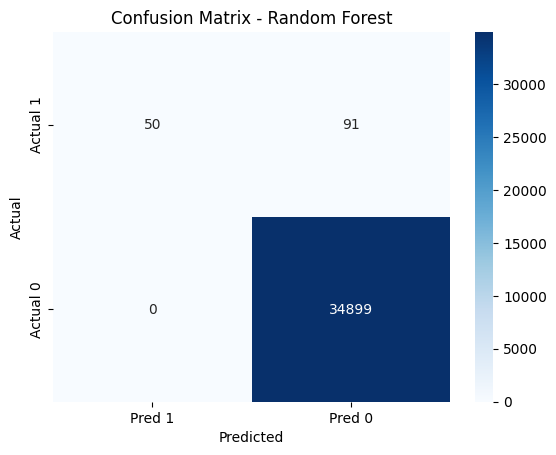


Classification Report for Random Forest:

              precision    recall  f1-score   support

           0     0.9974    1.0000    0.9987     34899
           1     1.0000    0.3546    0.5236       141

    accuracy                         0.9974     35040
   macro avg     0.9987    0.6773    0.7611     35040
weighted avg     0.9974    0.9974    0.9968     35040



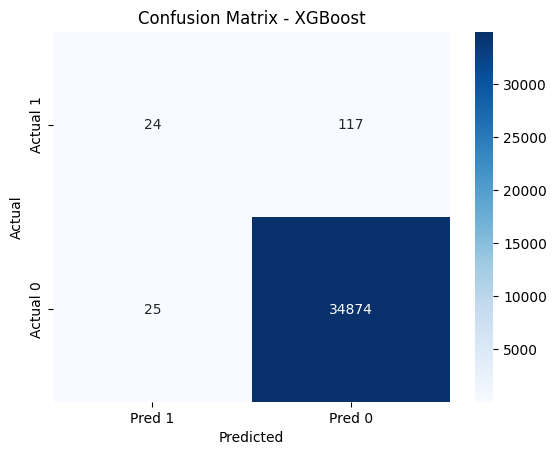


Classification Report for XGBoost:

              precision    recall  f1-score   support

           0     0.9967    0.9993    0.9980     34899
           1     0.4898    0.1702    0.2526       141

    accuracy                         0.9959     35040
   macro avg     0.7432    0.5847    0.6253     35040
weighted avg     0.9946    0.9959    0.9950     35040



In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import joblib  # For saving models

# Assuming your dataset is called `train`
building_ids = train['building_id'].unique()

# Store predictions and ground truth
all_y_test_rf, all_y_pred_rf = [], []
all_y_test_xgb, all_y_pred_xgb = [], []

for b_id in building_ids:
    df = train[train['building_id'] == b_id]

    # Skip if there's not enough data for splitting
    if df.shape[0] < 10 or df['anomaly'].nunique() < 2:
        continue

    X = df.drop(columns=["building_id", "anomaly"])
    y = df["anomaly"]

    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

    # RF
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)

    # Save the Random Forest model for this building
    joblib.dump(scaler, f'scaler_building_{b_id}.pkl')
    joblib.dump(rf, f'rf_model_building_{b_id}.pkl')

    # XGB
    xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)

    # Append
    all_y_test_rf.extend(y_test)
    all_y_pred_rf.extend(y_pred_rf)

    all_y_test_xgb.extend(y_test)
    all_y_pred_xgb.extend(y_pred_xgb)

# Plot confusion matrices
def plot_cm_and_metrics(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Pred 1", "Pred 0"], yticklabels=["Actual 1", "Actual 0"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred, digits=4))

# Final RF results
plot_cm_and_metrics(all_y_test_rf, all_y_pred_rf, "Random Forest")

# Final XGB results
plot_cm_and_metrics(all_y_test_xgb, all_y_pred_xgb, "XGBoost")

In [51]:
import os
import zipfile

# Define directory and output zip name
output_dir = '/kaggle/working'
zip_filename = 'models_output.zip'
zip_filepath = os.path.join(output_dir, zip_filename)

# Create zip file
with zipfile.ZipFile(zip_filepath, 'w') as zipf:
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            if file != zip_filename:  # Avoid zipping the zip file itself
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, output_dir)
                zipf.write(file_path, arcname)

print(f"Created zip file: {zip_filepath}")


Created zip file: /kaggle/working/models_output.zip


<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">
    So we saved our scalers and models which we will use in our Backend 
</p>